# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

**ЗАДАЧА ПРОЕКТА:**

На основании данных:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро) - *целевой признак*

**построить модель для определения стоимости автомобиля**

Критерии сравнения моделей:

- качество предсказания (RMSE должно быть меньше 2500)
- скорость предсказания
- время обучения


## Подготовка данных

### Загрузка данных

In [1]:
# подготавливаем рабочее пространство,
# загружаем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [2]:
# загружаем данные,
# выводим информацию по датасету,
# выводим первые 5 строк
data = pd.read_csv('/datasets/autos.csv')
display(data.info())
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Выводы
* датасет содержит 354 369 записей и 16 колонок
* некоторые параметры имеют пропущенные значения
* значения дат записаны в несоответствующем формате
* записи и названия колонок сделаны единообразно

### Анализ данных и преобразование

#### Форматы

In [3]:
# преобразуем тип данных параметров с датой из object в datetime
columns_date = data[['DateCrawled', 'DateCreated', 'LastSeen']]
for column in columns_date:
    data[column] = pd.to_datetime(data[column])
    display(data[column].dtypes)

dtype('<M8[ns]')

dtype('<M8[ns]')

dtype('<M8[ns]')

#### Параметры дат

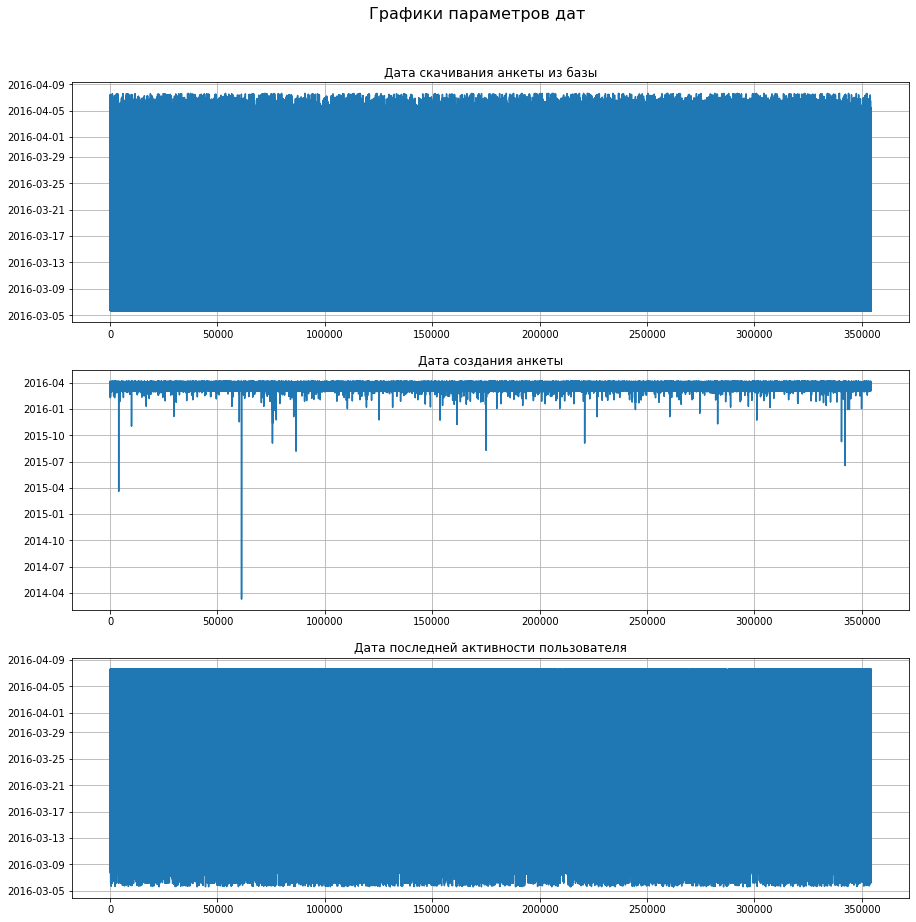

In [4]:
# визуализируем данные по параметрам дат
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle('Графики параметров дат', y=0.95, size=16)

data['DateCrawled'].plot(ax=axes[0], grid = True, title='Дата скачивания анкеты из базы')
data['DateCreated'].plot(ax=axes[1], grid = True, title='Дата создания анкеты')
data['LastSeen'].plot(ax=axes[2], grid = True, title='Дата последней активности пользователя');

In [5]:
# выводим объекты с датами создания анкет в 2014 - 2015 гг
data_DateCreated_14_15 = data[data['DateCreated'].between('2014-01-01', '2015-12-31')].sort_values(by='DateCreated')
display(data_DateCreated_14_15[['DateCrawled','DateCreated',  'LastSeen']])

,DateCrawled,DateCreated,LastSeen
61207,2016-03-16 11:48:06,2014-03-10,2016-04-07 04:46:24
4001,2016-03-23 14:42:46,2015-03-20,2016-04-07 03:45:01
342275,2016-03-05 21:44:26,2015-06-18,2016-04-05 17:46:09
86601,2016-04-02 19:47:40,2015-08-07,2016-04-07 09:15:23
175103,2016-03-08 17:57:45,2015-08-10,2016-04-05 20:46:54
75598,2016-03-14 08:43:53,2015-09-04,2016-03-15 14:16:58
221002,2016-03-15 01:56:49,2015-09-04,2016-03-15 15:49:29
340616,2016-03-05 21:51:02,2015-09-09,2016-04-05 17:46:04
9972,2016-03-05 17:53:53,2015-11-02,2016-03-17 15:46:57
161567,2016-03-05 14:31:01,2015-11-08,2016-04-06 23:15:36


**Выводы:**
* датасет содержит три параметра с датами
* **Дата скачивания анкеты из базы** - данные равномерно распределены в промежутке с 05.03.2016 по 09.04.2016; данный параметр не имеет отношения к ценообразованю
* **Дата создания анкеты** - основной массив данных имеет отношение к первым 4-м месяцам 2016 г., незначительная часть относится к 2015 г., при этом временной разрыв между созданием анкеты и датой активности находится в рамках условно актуального периода 6 месяцев; существует 1 объект с датой создания анкеты 2014 г. и последней датой активности в 2016 г.
* **Дата последней активности пользователя** - данные равномерно распределены в промежутке с 05.03.2016 по 09.04.2016, что  совпадает с периодом скачивания анкет
* включенные в датасет параметры с датами не влияют на процесс ценообразования; принято решение удалить параметры из выборки для предсказания

In [6]:
# удаляем параметры 'DateCrawled', 'DateCreated', 'LastSeen'
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis = 1)
display(data.shape)
display(data.head(5))

(354369, 13)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437


#### Аномалии

In [7]:
# выводим статистическую информацию по параметрам с численным форматом данных
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**исследуем параметр Price**

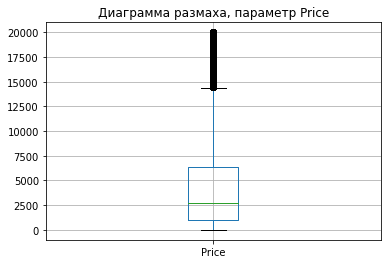

In [8]:
# строим диаграмму размаха
data.boxplot('Price')
plt.title('Диаграмма размаха, параметр Price');

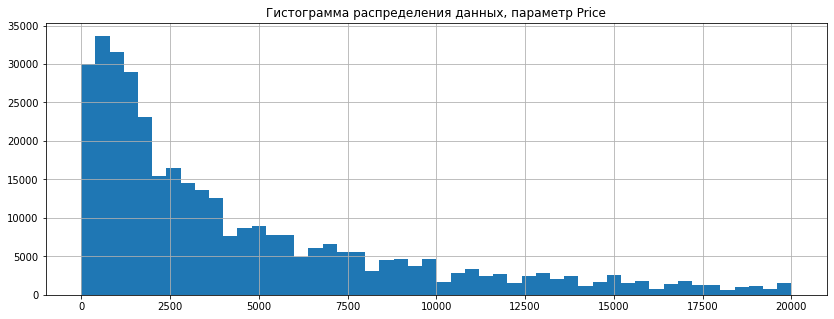

In [9]:
# строим гистограмму распределениея данных
plt.figure(figsize=(14, 5)) 
data['Price'].hist(bins = 50)
plt.title('Гистограмма распределения данных, параметр Price');

*Функция границы верхнего уса*

In [10]:
# создаем функцию, определяющую границы верхнего уса
def upper_limit(column):
    quantiles = data[column].quantile([0.25, 0.5, 0.75])
    q1 = quantiles[0.25]
    q3 = quantiles[0.75]
    upper_limit = q3 + 1.5*(q3 - q1)
    return upper_limit

In [11]:
# рассчитываем границу верхнего уса для параметра Price
print("Граница верхнего уса параметра Price:", upper_limit('Price'))

Граница верхнего уса параметра Price: 14425.0


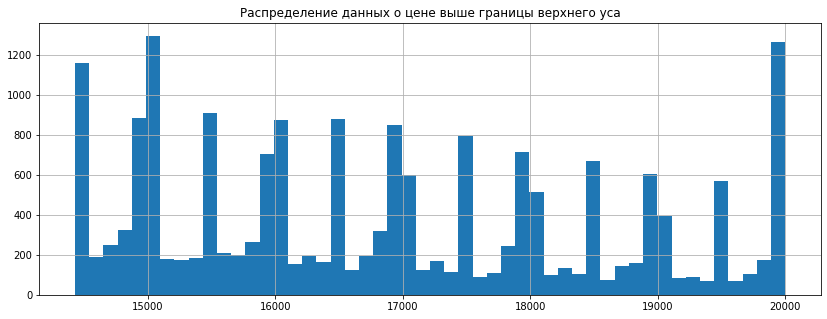

In [12]:
# проверяем распределение данных о цене выше границы верхнего уса
plt.figure(figsize=(14, 5)) 
data[data['Price'] > 14425]['Price'].hist(bins=50)
plt.title('Распределение данных о цене выше границы верхнего уса');

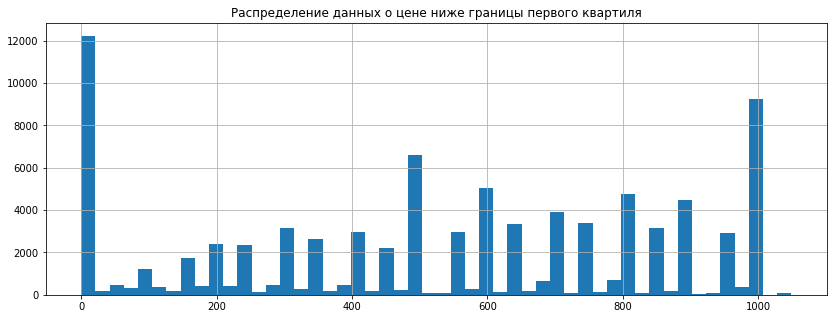

In [13]:
# проверяем распределение данных о цене ниже границы первого квартиля
plt.figure(figsize=(14, 5)) 
data[data['Price'] < data['Price'].quantile(0.25)]['Price'].hist(bins = 50)
plt.title('Распределение данных о цене ниже границы первого квартиля');

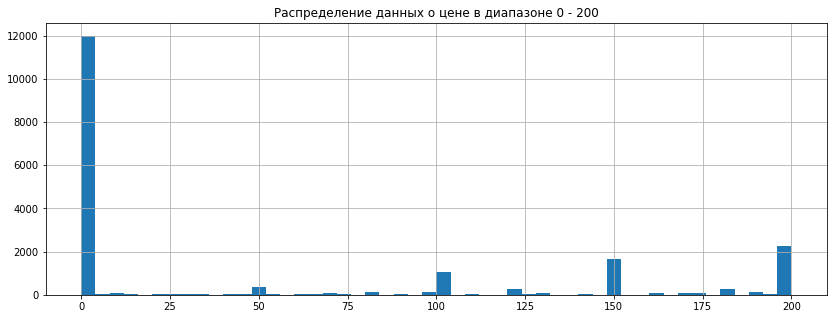

In [14]:
# проверяем распределение данных о цене в диапазоне 0 - 200
plt.figure(figsize=(14, 5)) 
data[data['Price'] <= 200]['Price'].hist(bins=50)
plt.title('Распределение данных о цене в диапазоне 0 - 200');

In [15]:
# выводим статистические данные по объектам в ценовом диапазоне 0 - 200
display(data[data['Price'] <= 200].describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,19448.000000,19448.000000,19448.000000,19448.000000,19448.000000,19448.0,19448.000000
mean,54.350370,2008.652766,70.151378,124328.979844,3.641094,0.0,46076.100216
std,76.532128,264.818430,227.028711,48762.910307,3.981941,0.0,26682.716492
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1069.000000
25%,0.000000,1995.000000,0.000000,125000.000000,0.000000,0.0,25852.750000
50%,0.000000,1999.000000,60.000000,150000.000000,2.000000,0.0,44534.000000
75%,120.000000,2003.000000,101.000000,150000.000000,7.000000,0.0,65933.000000
max,200.000000,9999.000000,15016.000000,150000.000000,12.000000,0.0,99998.000000


In [16]:
# выводим статистические данные по объектам с нулевым значением параметра Price
display(data[data['Price'] == 0].describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,10772.0,10772.000000,10772.000000,10772.000000,10772.000000,10772.0,10772.000000
mean,0.0,2008.848403,81.200056,124177.961381,3.697271,0.0,44937.204790
std,0.0,267.729824,235.273205,48423.379468,4.046864,0.0,26395.784541
min,0.0,1000.000000,0.000000,5000.000000,0.000000,0.0,1069.000000
25%,0.0,1996.000000,0.000000,125000.000000,0.000000,0.0,25336.750000
50%,0.0,2000.000000,75.000000,150000.000000,2.000000,0.0,42855.000000
75%,0.0,2005.000000,120.000000,150000.000000,7.000000,0.0,63668.750000
max,0.0,9999.000000,15016.000000,150000.000000,12.000000,0.0,99996.000000


**Выводы:**
* параметр Price является целевым в условиях данного проекта
* данные по параметру имеют ассиметричное правостороннее унимодальное распределение
* значение параметра равное нулю присутствует в 3% объектов
* среднее значение больше медианы: среднее = 4 416, медиана = 2 700
* анализ данных о цене выше границы верхнего уса исключил вопрос об их аномальности, т.к. они распределены равномерно с убывающим трендом в сторону увеличения цены, без скачков и разрывов в объяснимых количествах
* значения в диапазоне первого квартиля от 0 до 200 малочисленны, относятся к объектам с достаточно старым годом выпуска и низкой мощностью двигателя; можно предположить, что пользователи желают избавиться от старых авто за минимальную цену, сообщая индикатив этой цены; 
* объекты с нулевым значением цены не вносят положительного вклада в реализацию модели предсказания; принято решение их удалить

In [17]:
# исключаем объекты с нулевым значением цены из выборки
data = data[data['Price'] > 0]
display(data.shape)

(343597, 13)

In [18]:
# выводим статданные по обновленной выборке
data.Price.describe()

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

**исследуем параметр RegistrationYear**

In [19]:
# проверяем кол-во уникальных значений по гаждому году регистрации
data_reg_year = data['RegistrationYear'].value_counts().reset_index()\
        .rename(columns={'index':'RegistrationYear', 'RegistrationYear':'qnt'}). sort_values(by='RegistrationYear')
display(data_reg_year)

,RegistrationYear,qnt
60,1000,31
110,1001,1
119,1039,1
124,1111,1
80,1234,4
...,...,...
121,8500,1
138,8888,1
96,9000,2
111,9450,1


In [20]:
# выводим кол-во объектов с годами регистрации ранее 1910 и позднее 2016
print('Кол-во объектов ранее 1910:', data_reg_year[data_reg_year['RegistrationYear'] < 1910]['qnt'].sum())
print('Кол-во объектов позднее 2016:', data_reg_year[data_reg_year['RegistrationYear'] > 2016]['qnt'].sum())

Кол-во объектов ранее 1910: 53
Кол-во объектов позднее 2016: 13779


**Выводы:**
* выборка содержит достаточно много шумных данных по параметру RegistrationYear: 53 объекта имеют год регистрации ранее возникновения самой отрасли, 13 779 объектов имеют год регистрации позднее, чем дата последней активности пользователя
* дата регистрации автомобиля не может быть ранее начала развития отрасли (начало 20 века) и позднее, чем дата последней активности пользователя
* принято решение удалить из выборки объекты с ошибочной датой регистрации автомобиля, т.к. этот параметр существенен с точки зрения ценообразования 

In [21]:
# исключаем из выборки объекты с годом регистрации автомобиля ранее 1910 и позднее 2016
data = data[(data['RegistrationYear'] >= 1910) & (data['RegistrationYear'] < 2017)]
data.shape

(329765, 13)

In [22]:
# выводим статистические данные по параметру из обновленной выборки
data['RegistrationYear'].describe()

count    329765.000000
mean       2002.593583
std           6.927865
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

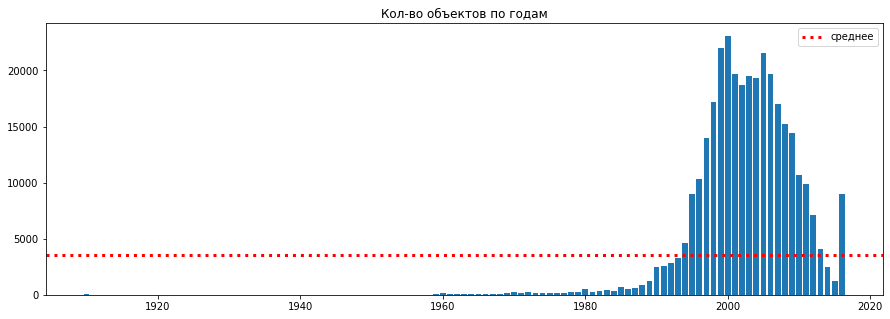

In [23]:
# проверяем кол-во уникальных значений по гаждому году регистрации
data_reg_year_new = data['RegistrationYear'].value_counts().reset_index()\
        .rename(columns={'index':'RegistrationYear', 'RegistrationYear':'qnt'}).sort_values(by='RegistrationYear')

plt.figure(figsize=(15,5))
plt.bar(data_reg_year_new['RegistrationYear'],data_reg_year_new['qnt'] )
plt.axhline(y= data_reg_year_new['qnt'].mean(), color='r', linestyle='dotted', linewidth=3, label='среднее')
plt.title('Кол-во объектов по годам')
plt.legend();

**Выводы:**
* кол-во объектов с регистрацией до 1960 г. является единичным
* длинный хвост слева фактически представлен аномалиями
* принято решение удалить данные аномальные значения из выборки

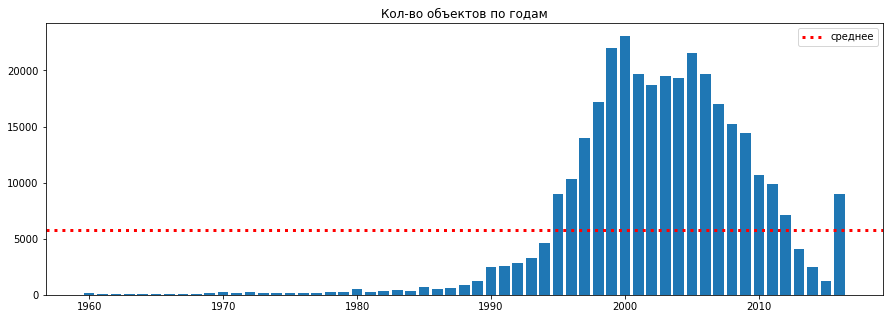

In [24]:
# обновляем выборку,
# проверяем новое распределение данных о годе регистрации
data = data[data['RegistrationYear'] > 1959]

data_reg_year_new = data['RegistrationYear'].value_counts().reset_index()\
        .rename(columns={'index':'RegistrationYear', 'RegistrationYear':'qnt'}).sort_values(by='RegistrationYear')

plt.figure(figsize=(15,5))
plt.bar(data_reg_year_new['RegistrationYear'],data_reg_year_new['qnt'] )
plt.axhline(y= data_reg_year_new['qnt'].mean(), color='r', linestyle='dotted', linewidth=3, label='среднее')
plt.title('Кол-во объектов по годам')
plt.legend();

**исследуем параметр Power**

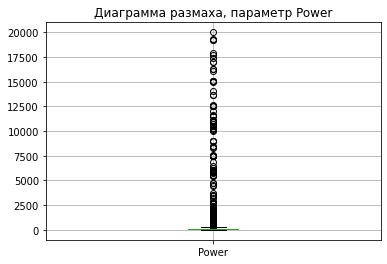

In [25]:
# строим диаграмму размаха
data.boxplot('Power')
plt.title('Диаграмма размаха, параметр Power');

In [26]:
# выводим стат данные по параметру Power
data['Power'].describe()

count    329478.000000
mean        111.959214
std         184.883693
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [27]:
# рассчитываем границу верхнего уса для параметра Price
print("Граница верхнего уса параметра Power:", upper_limit('Power'))

Граница верхнего уса параметра Power: 251.0


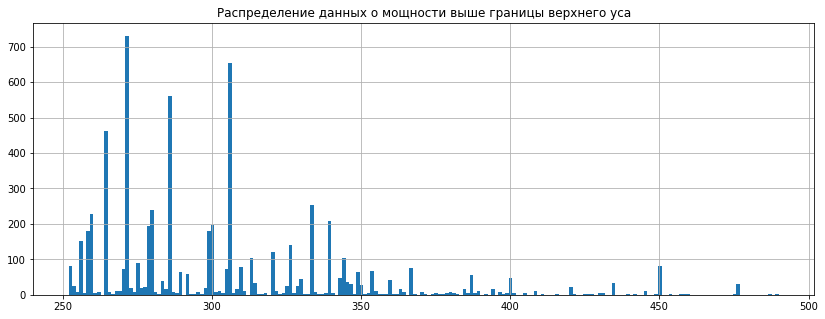

In [28]:
# проверяем распределение данных о мощности выше границы верхнего уса
plt.figure(figsize=(14, 5)) 
data[(data['Power'] > 251) & (data['Power'] < 500)]['Power'].hist(bins=200)
plt.title('Распределение данных о мощности выше границы верхнего уса');

In [29]:
# проверяем кол-во объектов с мощностью свыше 450 л.с.
print('Кол-во объектов с мощностью свыше 450 л.с.:', data[data['Power'] > 450]['Power'].value_counts().sum())

Кол-во объектов с мощностью свыше 450 л.с.: 465


In [30]:
# проверяем кол-во объектов с мощностью менее 10 л.с.
print('Кол-во объектов с мощностью менее 10 л.с.:\n', data[data['Power'] < 10]['Power'].value_counts())
print()
print('Всего:', data[data['Power'] < 10]['Power'].value_counts().sum())

Кол-во объектов с мощностью менее 10 л.с.:
 0    32731
5      100
4       30
1       25
6       11
7       10
2        9
3        8
8        6
9        4
Name: Power, dtype: int64

Всего: 32934


In [31]:
# выводим 5 случайных объектов с мощностью 0
data_power_zero = data[data["Power"] == 0]
display(data_power_zero.sample(5))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
51668,8400,suv,1965,manual,0,other,90000,6,petrol,chevrolet,no,0,49401
87195,2800,sedan,1977,manual,0,other,150000,2,gasoline,mercedes_benz,no,0,72488
19645,700,sedan,1991,manual,0,100,150000,0,NaN,audi,yes,0,27798
117797,1,NaN,1995,manual,0,1_reihe,150000,6,petrol,peugeot,NaN,0,72415
171384,3200,small,2005,manual,0,polo,150000,9,petrol,volkswagen,no,0,14550


In [32]:
# проверяем группировку объектов с нулевой мощностью по параметру Model
display(data_power_zero.groupby('Model')['Power'].count().sort_values(ascending=False))

Model
other         2656
golf          1989
corsa         1450
polo          1324
3er           1268
              ... 
serie_1          1
9000             1
materia          1
elefantino       1
b_max            1
Name: Power, Length: 242, dtype: int64

**Выводы:**
* отраслевой диапазон мощности двигателей находится в промежутке 10 - 450 л.с.
* транспортные средства с мощность менее 10 л.с. относятся к раритетным, которые не продаются через массовые приложения, либо скорее к лассу мотороллеров
* транспортные средства мощность свыше 450 и до 700 л.с. уникальны, не носят массовый характер, скорее продаются через каналы продаж, отличные от массовых приложений
* автомобили в диапазоне 700 - 1000 л.с. сил являются редкими
* автомобили свыше 1000 л.с. не доступны потребителю
* параметр Power / мощность является одним из ключевых с точки зрения ценообразования
* общее кол-во объектов в обновленном датасете с аномальными значениями составляет 33 539 или порядка 10%
* принято решение произвести замену аномальных данных о мощности средними данными по заявленой модели

In [33]:
# сoздаем перменную с аномальными значениями мощности
power_abnorm = data[(data['Power'] < 10) | (data['Power'] > 450)]
display(power_abnorm.shape)

(33399, 13)

In [34]:
# заменяем все аномальные значения мощности на NaN,
# чтобы корректно рассчитать средние значения по моделям
data.loc[data.index.isin(power_abnorm.index),'Power'] = np.nan
display(data['Power'].isna().sum())

33399

In [35]:
# рассчитываем среднее значение мощности по моделям
power_model_avg = data.groupby('Model')['Power'].mean().round()
display(power_model_avg.sort_values(ascending=False).head(5))
display(power_model_avg.shape)

Model
m_reihe               340.0
cayenne               334.0
range_rover_evoque    296.0
6er                   295.0
911                   286.0
Name: Power, dtype: float64

(250,)

In [36]:
# производим замену аномальных данных о мощности средними данными по заявленой модели
data = data.set_index('Model')
data['Power'] = data['Power'].fillna(power_model_avg)
data = data.reset_index()
display(data.head())

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
0,golf,480,NaN,1993,manual,104.0,150000,0,petrol,volkswagen,NaN,0,70435
1,NaN,18300,coupe,2011,manual,190.0,125000,5,gasoline,audi,yes,0,66954
2,grand,9800,suv,2004,auto,163.0,125000,8,gasoline,jeep,NaN,0,90480
3,golf,1500,small,2001,manual,75.0,150000,6,petrol,volkswagen,no,0,91074
4,fabia,3600,small,2008,manual,69.0,90000,7,gasoline,skoda,no,0,60437


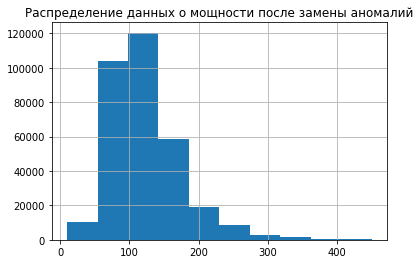

In [37]:
# Проверяем распределение данных после замены аномальных значений
data['Power'].hist()
plt.title('Распределение данных о мощности после замены аномалий');

**исследуем параметр Kilometer**

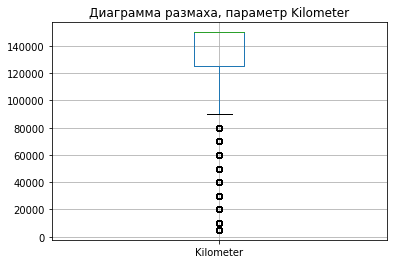

In [38]:
# строим диаграмму размаха
data.boxplot('Kilometer')
plt.title('Диаграмма размаха, параметр Kilometer');

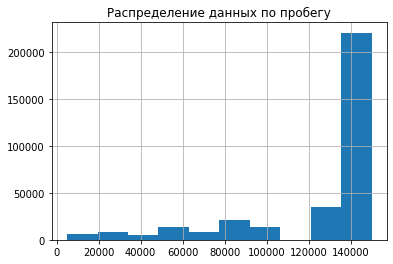

In [39]:
# строим гистограмму распределения данных по параметру Kilometer
data.Kilometer.hist()
plt.title('Распределение данных по пробегу');

In [40]:
# проверяем распределение кол-ва объектов с пробегом свыше 120 000
data[data['Kilometer'] > 120000]['Kilometer'].value_counts()

150000    220444
125000     34402
Name: Kilometer, dtype: int64

**Выводы:**
* большинство автомобилей представленных в датасете имеют достаточно большой пробег, равный 150 000 км.
* аномалий не выявлено

**исследуем параметр RegistrationMonth**

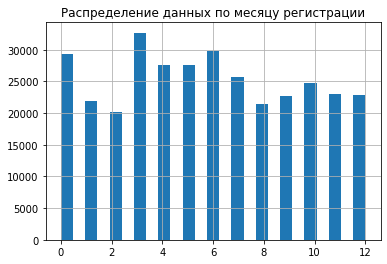

In [41]:
# строим гистограмму распределенеия данных
data['RegistrationMonth'].hist(bins=25)
plt.title('Распределение данных по месяцу регистрации');

In [42]:
# проверяем распределение значений по годам
data_year_pvt = data.pivot_table(index = 'RegistrationYear', columns="RegistrationMonth"\
                                 , aggfunc={"RegistrationMonth":'count'})
display(data_year_pvt)

RegistrationMonth                                          \
RegistrationMonth                0       1       2       3       4       5    
RegistrationYear                                                              
1960                           67.0    16.0     2.0    12.0     3.0     3.0   
1961                            3.0     5.0     6.0     1.0     5.0     3.0   
1962                            4.0     6.0     1.0     4.0     4.0     5.0   
1963                            7.0     4.0     2.0     4.0     3.0     6.0   
1964                            7.0     9.0     6.0     2.0     3.0     4.0   
1965                            9.0    11.0     4.0     6.0     9.0     7.0   
1966                           11.0    11.0     3.0    14.0     5.0     5.0   
1967                            7.0    10.0     7.0     7.0     5.0     8.0   
1968                           10.0    13.0     2.0     9.0     8.0     8.0   
1969                           13.0    15.0     5.0    17.0     8.0    11.0   
1970                          127.0    28.0    14.0    16.0    19.0     8.0   
1971                           15.0    14.0    16.0    12.0    11.0    15.0   
1972                           26.0    23.0    15.0    21.0    20.0    26.0   
1973                           17.0    15.0    13.0    21.0    13.0    11.0   
1974                           20.0     9.0     7.0    20.0    25.0    21.0   
1975                           17.0    16.0     8.0    15.0    11.0     7.0   
1976                           17.0    15.0    13.0    19.0     8.0    12.0   
1977                           25.0    10.0     7.0    24.0     9.0    17.0   
1978                           34.0    25.0    16.0    35.0    14.0    11.0   
1979                           25.0    18.0    20.0    36.0    25.0    18.0   
1980                          210.0    48.0    26.0    37.0    30.0    31.0   
1981                           32.0    25.0    12.0    31.0    27.0    25.0   
1982                           41.0    14.0    22.0    38.0    21.0    20.0   
1983                           44.0    34.0    23.0    45.0    36.0    32.0   
1984                           38.0    37.0    22.0    39.0    53.0    41.0   
1985                          192.0    46.0    36.0    44.0    54.0    52.0   
1986                           71.0    37.0    19.0    52.0    42.0    32.0   
1987                           88.0    34.0    29.0    37.0    60.0    50.0   
1988                          122.0    56.0    43.0    98.0    77.0    83.0   
1989                          186.0    69.0    51.0   118.0   117.0   111.0   
1990                          688.0   155.0   116.0   204.0   174.0   155.0   
1991                          351.0   204.0   164.0   265.0   220.0   235.0   
1992                          355.0   189.0   175.0   292.0   273.0   202.0   
1993                          490.0   203.0   166.0   387.0   348.0   245.0   
1994                          673.0   265.0   235.0   396.0   440.0   380.0   
1995                         1952.0   523.0   430.0   761.0   644.0   768.0   
1996                         1460.0   609.0   543.0   901.0   847.0   827.0   
1997                         1790.0   920.0   836.0  1272.0  1208.0  1067.0   
1998                         1984.0   996.0   912.0  1642.0  1215.0  1189.0   
1999                         2221.0  1413.0  1275.0  2306.0  1766.0  1645.0   
2000                         4046.0  1658.0  1345.0  2207.0  1622.0  1991.0   
2001                         1573.0  1398.0  1212.0  2046.0  1563.0  1770.0   
2002                         1162.0  1197.0  1496.0  1847.0  1557.0  1554.0   
2003                         1061.0  1310.0  1164.0  2401.0  1583.0  1630.0   
2004                          882.0  1242.0  1127.0  1745.0  1942.0  1556.0   
2005                         1909.0  1222.0  1176.0  1942.0  1662.0  2048.0   
2006                          754.0  1295.0  1138.0  1918.0  1684.0  1657.0   
2007                          536.0  1114.0   964.0  1726.0  1382.0 

In [43]:
# выводим 5 случайных значений с нулевым месяцем
display(data[data['RegistrationMonth'] == 0].sample(5))

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
92992,lupo,1900,small,2000,manual,50.0,150000,0,petrol,volkswagen,NaN,0,33758
141659,twingo,150,NaN,2016,NaN,63.0,150000,0,petrol,renault,yes,0,38518
55736,megane,300,coupe,1997,manual,111.0,150000,0,NaN,renault,yes,0,6667
35248,5er,15000,sedan,2007,auto,235.0,150000,0,gasoline,bmw,NaN,0,30175
232994,micra,500,small,1997,manual,60.0,150000,0,petrol,nissan,no,0,49086


**Выводы:**
* в датасете содержится порядка 10% объектов, у которых маесяц регистрации равен 0
* кол-во нулевых значений пропорционально изменяется в зависимости от бощего кол-ва значений в срезах (по годам, по моделям, по типам транспортного средства, по индексам....)
* значение месяца регистрации, равного нулю не является нормальным, но при этом не выявлено никаких взаимосвязей с другими параметрами
* принято решение сохранить данные как есть

**исследуем параметр NumberOfPictures**

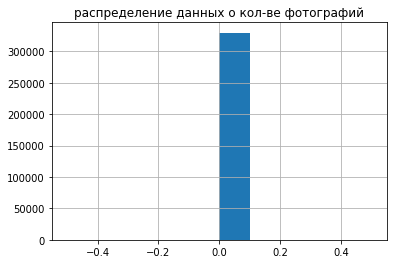

In [44]:
# строим гистограмму распределения данных
data['NumberOfPictures'].hist()
plt.title('распределение данных о кол-ве фотографий');

**Выводы:**
* информация о кол-ве фотографий полностью отсутствует
* можно предположить, что это техническая ошибка данных
* в рамках данного проекта принято решенеи удалить параметр

In [45]:
data = data.drop('NumberOfPictures', axis=1)
display(data.shape)

(329478, 12)

**исследуем параметр PostalCode**

In [46]:
data['PostalCode'].describe()

count    329478.000000
mean      50778.370258
std       25763.951111
min        1067.000000
25%       30457.000000
50%       49624.000000
75%       71336.000000
max       99998.000000
Name: PostalCode, dtype: float64

**Выводы:**
* аномалий не наблюдается

#### Пропуски

In [47]:
# проверяем наличие пропусков
print('Кол-во пропусков:\n', data.isna().sum().sort_values(ascending=False))

Кол-во пропусков:
 NotRepaired          59759
FuelType             24105
VehicleType          19897
Model                15519
Gearbox              15517
Power                 4531
Price                    0
RegistrationYear         0
Kilometer                0
RegistrationMonth        0
Brand                    0
PostalCode               0
dtype: int64


**Выводы:**
* параметры с пропущенными значениями играют роль в процессе ценообразования
* кол-во пропущенных значений существенно; принято решение не удалять пропуски, а найти способы замены
* подбор данных для замены пропущенных значений будет опираться на связи Brand - Registrationyear - Model
* принято решение создать 2 дополнительных параметра: Brand_Model и Brand_Reg_Year

In [48]:
# добавляем в датасет параметр Brand_Model
data['Brand_Model'] = data['Brand'].astype('str') + data['Model'].astype('str')
print('Кол-во уникальных комбинаций "Brand - Model":', data['Brand_Model'].nunique())

Кол-во уникальных комбинаций "Brand - Model": 337


In [49]:
# добавляем в датасет параметр Brand_RegYear
data['Brand_RegYear'] = data['Brand'].astype('str') + data['RegistrationYear'].astype('str')
print('Кол-во уникальных комбинаций "Brand - Registrationyear":', data['Brand_RegYear'].nunique())

Кол-во уникальных комбинаций "Brand - Registrationyear": 1669


**исследуем пропуски по параметру NotRepaired**

In [50]:
# выводим кол-во уникальных значений
data.NotRepaired.value_counts()

no     236786
yes     32933
Name: NotRepaired, dtype: int64

In [51]:
# производим замену пропущенных значений на 'no info'
data['NotRepaired'] = data['NotRepaired'].fillna('no info')
data.NotRepaired.value_counts()

no         236786
no info     59759
yes         32933
Name: NotRepaired, dtype: int64

**исследуем пропуски по параметру Model**

In [52]:
# выводим 5 случайных объектов с пропущенным значением модели
display(data[data['Model'].isna()].sample(5))

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear
216027,NaN,1550,NaN,1995,manual,NaN,150000,4,petrol,bmw,no,65549,bmwnan,bmw1995
226189,NaN,11000,NaN,1960,NaN,250.0,5000,1,petrol,sonstige_autos,no info,49661,sonstige_autosnan,sonstige_autos1960
228559,NaN,14250,NaN,2011,auto,143.0,125000,2,NaN,bmw,no,76889,bmwnan,bmw2011
145931,NaN,800,NaN,2016,manual,60.0,125000,7,NaN,peugeot,no,13403,peugeotnan,peugeot2016
61442,NaN,300,small,1999,manual,NaN,125000,7,petrol,ford,no info,65555,fordnan,ford1999


In [53]:
# проверяем возможные комбинации модель - год регистрации - бренд
data.groupby(['Brand', 'RegistrationYear', 'Model'])['Price'].count()

Brand       RegistrationYear  Model   
alfa_romeo  1960              145          1
            1965              other        1
            1967              other        2
            1968              other        2
            1969              other        1
                                          ..
volvo       2016              other        9
                              v40         19
                              v50          5
                              v70          1
                              xc_reihe     4
Name: Price, Length: 6030, dtype: int64

**Выводы:**
* параметр Model имеет 15 519 объектов с пропущенным значением модели
* принято решение заполнить пропуски максимальным по кол-ву объектов значением в связке Brand - RegistrationYear - Model, т.е. присвоить значения наиболее популярных моделей в данном бренде по году регистрации 

In [54]:
# проверяем кол-во уникальных комбинаций "Brand - Registrationyear - Model"
brand_regyear_model = data.groupby(['Brand_RegYear', 'Model'])['Price'].count()
brand_regyear_model_max = brand_regyear_model.loc[brand_regyear_model.groupby('Brand_RegYear').idxmax(skipna=True)]\
.reset_index().drop('Price', axis=1)
print('Кол-во уникальных комбинаций "Brand - Registrationyear - Model":', brand_regyear_model_max['Brand_RegYear'].nunique())
display(brand_regyear_model_max.head())

Кол-во уникальных комбинаций "Brand - Registrationyear - Model": 1592


,Brand_RegYear,Model
0,alfa_romeo1960,145
1,alfa_romeo1965,other
2,alfa_romeo1967,other
3,alfa_romeo1968,other
4,alfa_romeo1969,other


In [55]:
# проверяем объекты, не вошедшие в список
br_y_m_lst = brand_regyear_model_max['Brand_RegYear']
print('Список объектов в комбинации "Brand - RegistrationYear" с отсутствующим названием модели:\n'\
      ,(data[~data['Brand_RegYear'].isin(br_y_m_lst)].groupby('Brand_RegYear')['Model'].count()))

Список объектов в комбинации "Brand - RegistrationYear" с отсутствующим названием модели:
 Brand_RegYear
audi1960        0
audi1964        0
chrysler2015    0
daewoo1994      0
daihatsu1991    0
               ..
trabant1998     0
trabant1999     0
trabant2000     0
trabant2004     0
trabant2008     0
Name: Model, Length: 77, dtype: int64


In [56]:
# создаем цикл замены пропущенных значений параметра Model по максимальному кол-ву объектов в связке бренд - год
car_model = pd.DataFrame(data.groupby('Brand_RegYear')['Model'].value_counts())
car_model.columns = ['count']
car_model = pd.DataFrame(car_model['count'].sort_values(ascending=False)).reset_index()
for i in tqdm(car_model['Brand_RegYear']):
    maximum = car_model[car_model['Brand_RegYear'] == i]['count'].max()
    model = car_model.query('count == @maximum and Brand_RegYear == @i')['Model'].reset_index(drop=True)
    data.loc[data['Brand_RegYear'] == i, 'Model'] = data.loc[data['Brand_RegYear'] == i, 'Model'].fillna(model[0])
display(data['Model'].isna().sum())

100%|██████████| 6030/6030 [04:41<00:00, 21.41it/s]


2646

In [57]:
# проверяем, что объекты, по которым не прошла замена модели, не относятся к списку br_y_m_lst,
# т.е. онформация о модели отсутствует
display(~data[data['Model'].isna()]['Brand_RegYear'].isin(br_y_m_lst).value_counts())

False   -2647
Name: Brand_RegYear, dtype: int64

In [58]:
# заменяем отсутствующие значения модели на "no model"
data['Model'] = data['Model'].fillna('no model')
display(data['Model'].isna().sum())

0

**исследуем пропуски по параметру FuelType**

In [59]:
# выводим кол-во уникальных значений
data.FuelType.value_counts()

petrol      204515
gasoline     94833
lpg           5023
cng            533
hybrid         220
other          162
electric        87
Name: FuelType, dtype: int64

In [60]:
# проверяем возможные комбинации тип топлива - модель - бренд
data.groupby(['Brand', 'Model', 'FuelType'])['Price'].count()

Brand       Model     FuelType
alfa_romeo  145       petrol       37
            147       gasoline    132
                      lpg          16
                      petrol      381
            156       gasoline    188
                                 ... 
volvo       v70       lpg          23
                      petrol      335
            xc_reihe  gasoline    230
                      lpg           4
                      petrol       25
Name: Price, Length: 984, dtype: int64

**Выводы:**
* по параметру FuelType выявлено 24 105 пропущенных значений
* принято решение заполнить пропуски максимальным по кол-ву объектов значением в связке Brand - Model - FuelType

In [61]:
# проверяем кол-во уникальных комбинаций "Brand - Model - FuelType"
brand_model_ftype = data.groupby(['Brand_Model', 'FuelType'])['Price'].count()
brand_model_ftype_max = brand_model_ftype.loc[brand_model_ftype.groupby('Brand_Model').idxmax(skipna=True)]\
.reset_index().drop('Price', axis=1)
print('Кол-во уникальных комбинаций "Brand - Model - FuelType":', brand_model_ftype_max['Brand_Model'].nunique())
display(brand_model_ftype_max.head())

Кол-во уникальных комбинаций "Brand - Model - FuelType": 337


,Brand_Model,FuelType
0,alfa_romeo145,petrol
1,alfa_romeo147,petrol
2,alfa_romeo156,petrol
3,alfa_romeo159,gasoline
4,alfa_romeonan,petrol


In [62]:
# создаем цикл замены пропущенных значений параметра FuelType по максимальному кол-ву объектов в связке бренд - модель
car_ftype = pd.DataFrame(data.groupby('Brand_Model')['FuelType'].value_counts())
car_ftype.columns = ['count']
car_ftype = pd.DataFrame(car_ftype['count'].sort_values(ascending=False)).reset_index()
for i in tqdm(car_ftype['Brand_Model']):
    maximum = car_ftype[car_ftype['Brand_Model'] == i]['count'].max()
    model = car_ftype.query('count == @maximum and Brand_Model == @i')['FuelType'].reset_index(drop=True)
    data.loc[data['Brand_Model'] == i, 'FuelType'] = data.loc[data['Brand_Model'] == i, 'FuelType'].fillna(model[0])
display(data['FuelType'].isna().sum())

100%|██████████| 1084/1084 [00:55<00:00, 19.44it/s]


0

In [63]:
# проверяем оставшийся объект с пропущенным значеним
display(data[data['FuelType'].isna()])

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear


In [64]:
# заполняем оставшееся пропущенное значение согласно информации из открытых источников
data['FuelType'] = data['FuelType'].fillna('petrol')
display(data['FuelType'].isna().sum())

0

**исследуем пропуски по параметру VehicleType**

In [65]:
# проверяем кол-во уникальных значений по признаку VehicleType
# и долю каждого типа в данных
data_vtype = data.VehicleType.value_counts().sort_values(ascending=False).reset_index().rename(columns={'index':'VehicleType'\
                                                                                                        , 'VehicleType':'qnt'})
data_vtype['share'] = data_vtype['qnt'] / len(data)
display(data_vtype)

,VehicleType,qnt,share
0,sedan,89298,0.271029
1,small,77986,0.236696
2,wagon,63692,0.193312
3,bus,28337,0.086006
4,convertible,19844,0.060229
5,coupe,15613,0.047387
6,suv,11760,0.035693
7,other,3051,0.009260


In [66]:
# выводим 5 случайных объектов с пропущенным значением параметра VehicleType
display(data[data['VehicleType'].isna()].sample(5))

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear
249553,corsa,250,NaN,2016,manual,45.0,150000,0,petrol,opel,no info,2763,opelcorsa,opel2016
176356,golf,1999,NaN,1995,auto,69.0,125000,0,petrol,volkswagen,no info,51674,volkswagengolf,volkswagen1995
22371,1er,20000,NaN,2006,manual,122.0,150000,4,gasoline,bmw,yes,40231,bmw1er,bmw2006
213854,punto,700,NaN,2000,manual,68.0,150000,0,petrol,fiat,no,46047,fiatpunto,fiat2000
242755,twingo,2222,NaN,2000,NaN,NaN,125000,0,petrol,renault,no info,51647,renaultnan,renault2000


In [67]:
# проверяем среднюю мощность для каждого типа
display(data.groupby('VehicleType')['Power'].mean().round().sort_values(ascending=False))

VehicleType
suv            165.0
coupe          159.0
wagon          139.0
convertible    136.0
sedan          134.0
bus            118.0
other          105.0
small           74.0
Name: Power, dtype: float64

In [68]:
# проверяем возможные комбинации тип - модель - бренд
data.groupby(['Brand', 'Model', 'VehicleType'])['Price'].count()

Brand       Model     VehicleType
alfa_romeo  145       coupe            2
                      other            1
                      sedan           12
                      small           19
            147       coupe           29
                                    ... 
volvo       v70       sedan            1
                      wagon          602
            xc_reihe  sedan            3
                      suv            216
                      wagon           41
Name: Price, Length: 1503, dtype: int64

**Выводы:**
* по параметру VehicleType выявлено 19 897 пропущенных значений
* принято решение заполнить пропуски максимальным по кол-ву объектов значением в связке Brand - Model - VehicleType

In [69]:
# проверяем кол-во уникальных комбинаций "Brand - Model - FuelType"
brand_model_vtype = data.groupby(['Brand_Model', 'VehicleType'])['Price'].count()
brand_model_vtype_max = brand_model_vtype.loc[brand_model_vtype.groupby('Brand_Model').idxmax(skipna=True)]\
.reset_index().drop('Price', axis=1)
print('Кол-во уникальных комбинаций "Brand - Model - VehicleType":', brand_model_vtype_max['Brand_Model'].nunique())
display(brand_model_vtype_max.head())

Кол-во уникальных комбинаций "Brand - Model - VehicleType": 337


,Brand_Model,VehicleType
0,alfa_romeo145,small
1,alfa_romeo147,sedan
2,alfa_romeo156,wagon
3,alfa_romeo159,wagon
4,alfa_romeonan,sedan


In [70]:
# создаем цикл замены пропущенных значений параметра VehicleType по максимальному кол-ву объектов в связке бренд - модель
car_vtype = pd.DataFrame(data.groupby('Brand_Model')['VehicleType'].value_counts())
car_vtype.columns = ['count']
car_vtype = pd.DataFrame(car_vtype['count'].sort_values(ascending=False)).reset_index()
for i in tqdm(car_vtype['Brand_Model']):
    maximum = car_vtype[car_vtype['Brand_Model'] == i]['count'].max()
    model = car_vtype.query('count == @maximum and Brand_Model == @i')['VehicleType'].reset_index(drop=True)
    data.loc[data['Brand_Model'] == i, 'VehicleType'] = data.loc[data['Brand_Model'] == i, 'VehicleType'].fillna(model[0])
display(data['VehicleType'].isna().sum())

100%|██████████| 1650/1650 [01:17<00:00, 21.17it/s]


0

In [71]:
display(data[data['VehicleType'].isna()])

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear


In [72]:
# производим замену согласно информации, доступной в открытых источниках
data['VehicleType'] = data['VehicleType'].fillna('sedan')
display(data['VehicleType'].isna().sum())

0

**исследуем пропуски по параметру Gearbox**

In [73]:
# выводим кол-во уникальных значений
display(data['Gearbox'].value_counts())

manual    250977
auto       62984
Name: Gearbox, dtype: int64

In [74]:
# проверяем возможные комбинации тип коробки - модель - бренд
display(data.groupby(['Brand_Model', 'Gearbox'])['Gearbox'].count())

Brand_Model    Gearbox
alfa_romeo145  manual      38
alfa_romeo147  auto        26
               manual     489
alfa_romeo156  auto        43
               manual     529
                         ... 
volvov60       manual      25
volvov70       auto       221
               manual     374
volvoxc_reihe  auto       190
               manual      68
Name: Gearbox, Length: 648, dtype: int64

**Выводы:**
* по параметру Gearbox выявлено 15 517 пропущенных значений
* принято решение заполнить пропуски максимальным по кол-ву объектов значением в связке Brand - Model - Gearbox

In [75]:
# проверяем кол-во уникальных комбинаций "Brand - Model - Gearbox"
brand_model_gbox = data.groupby(['Brand_Model', 'Gearbox'])['Price'].count()
brand_model_gbox_max = brand_model_gbox.loc[brand_model_gbox.groupby('Brand_Model').idxmax(skipna=True)]\
.reset_index().drop('Price', axis=1)
print('Кол-во уникальных комбинаций "Brand - Model - Gearbox":', brand_model_gbox_max['Brand_Model'].nunique())
display(brand_model_gbox_max.head())

Кол-во уникальных комбинаций "Brand - Model - Gearbox": 337


,Brand_Model,Gearbox
0,alfa_romeo145,manual
1,alfa_romeo147,manual
2,alfa_romeo156,manual
3,alfa_romeo159,manual
4,alfa_romeonan,manual


In [76]:
# создаем цикл замены пропущенных значений параметра Gearbox по максимальному кол-ву объектов в связке бренд - модель
car_gbox = pd.DataFrame(data.groupby('Brand_Model')['Gearbox'].value_counts())
car_gbox.columns = ['count']
car_gbox = pd.DataFrame(car_gbox['count'].sort_values(ascending=False)).reset_index()
for i in tqdm(car_gbox['Brand_Model']):
    maximum = car_gbox[car_gbox['Brand_Model'] == i]['count'].max()
    model = car_gbox.query('count == @maximum and Brand_Model == @i')['Gearbox'].reset_index(drop=True)
    data.loc[data['Brand_Model'] == i, 'Gearbox'] = data.loc[data['Brand_Model'] == i, 'Gearbox'].fillna(model[0])
display(data['Gearbox'].isna().sum())

100%|██████████| 648/648 [00:31<00:00, 20.84it/s]


0

In [77]:
# выводим объект с оставшимся незаполненным параметром
display(data[data['Gearbox'].isna()])

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear


In [78]:
# производим замену согласно информации, доступной в открытых источниках
data['Gearbox'] = data['Gearbox'].fillna('auto')
display(data['Gearbox'].isna().sum())

0

**исследуем пропуски по параметру Power**

In [79]:
# выводим 5 случайных объектов с пропущенным значением мощности
display(data[data['Power'].isna()].sample(5))

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear
328191,3er,1200,sedan,2000,manual,NaN,150000,0,petrol,bmw,no info,52372,bmwnan,bmw2000
254037,other,500,small,2006,manual,NaN,150000,3,petrol,hyundai,yes,45772,hyundainan,hyundai2006
147938,micra,400,suv,1995,auto,NaN,125000,7,cng,nissan,no info,65936,nissannan,nissan1995
215074,80,450,sedan,1991,manual,NaN,150000,0,petrol,audi,no info,24622,audinan,audi1991
199677,no model,50,sedan,1990,manual,NaN,150000,1,petrol,sonstige_autos,no info,37431,sonstige_autosnan,sonstige_autos1990


In [80]:
# обновляем данные о среднем значении мощности
power_model_avg = data.groupby('Model')['Power'].mean().round()
display(power_model_avg.sort_values(ascending=False).head(5))
display(power_model_avg.shape)

Model
m_reihe               340.0
cayenne               333.0
range_rover_evoque    296.0
6er                   294.0
911                   286.0
Name: Power, dtype: float64

(251,)

In [81]:
# производим замену пропущенных данных о мощности средними данными по заявленой модели
data = data.set_index('Model')
data['Power'] = data['Power'].fillna(power_model_avg)
data = data.reset_index()
display(data['Power'].isna().sum())

1

In [82]:
# выводим объект с оставшимся незаполненным параметром
display(data[data['Power'].isna()])

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear
217784,serie_1,3800,wagon,1978,manual,NaN,30000,0,gasoline,land_rover,no info,49824,land_roverserie_1,land_rover1978


In [83]:
# заполняем оставшееся пропущенное значение согласно информации из открытых источников
data['Power'] = data['Power'].fillna(50)
display(data['Power'].isna().sum())

0

**финальная проверка пропусков**

In [84]:
# проверяем наличие пропусков
print('Кол-во пропусков после обработки:\n', data.isna().sum().sort_values(ascending=False))

Кол-во пропусков после обработки:
 Model                0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
PostalCode           0
Brand_Model          0
Brand_RegYear        0
dtype: int64


#### Дубликаты

In [85]:
# проверяем наличие дубликатов
print('Кол-во абсолютных дубликатов:\n', data.duplicated().sum())

Кол-во абсолютных дубликатов:
 20838


In [86]:
# выводим продублированные значения
data_dupl_lst = data.duplicated(keep=False).to_frame().rename(columns={0:'dupl'})
data_dupl = data_dupl_lst[data_dupl_lst['dupl'] == True]
display(data[data.index.isin(data_dupl.index)].sort_values(by='Model', ascending = True).head(10))

,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Brand_Model,Brand_RegYear
250780,100,2000,sedan,1991,manual,133.0,150000,1,petrol,audi,no,94569,audi100,audi1991
2902,100,1399,sedan,1993,manual,150.0,150000,0,petrol,audi,no,25541,audi100,audi1993
204988,100,2500,sedan,1991,manual,133.0,150000,6,petrol,audi,no,31303,audi100,audi1991
291963,100,1499,sedan,1993,manual,150.0,150000,0,petrol,audi,no,25541,audi100,audi1993
223066,100,990,sedan,1991,auto,98.0,150000,4,petrol,audi,no info,85567,audi100,audi1991
222502,100,2150,sedan,1988,manual,136.0,150000,4,petrol,audi,no,32425,audi100,audi1988
130525,100,1150,sedan,1991,manual,133.0,150000,12,petrol,audi,no,65558,audi100,audi1991
158765,100,3800,sedan,1985,manual,90.0,100000,10,petrol,audi,no,47443,audi100,audi1985
155223,100,1299,sedan,1993,manual,150.0,150000,0,petrol,audi,no,25541,audi100,audi1993
45911,100,950,sedan,1991,manual,136.0,100000,6,petrol,audi,no,8451,audi100,audi1991


**Выводы:**
* выявлено 20 838 абсолютных дубликатов
* принято решение удалить дубликаты

In [87]:
# удаляем дубликаты
data = data.drop_duplicates().reset_index()
print('Кол-во абсолютных дубликатов после обработки:\n', data.duplicated().sum())
data.shape

Кол-во абсолютных дубликатов после обработки:
 0


(308640, 15)

## Обучение моделей

### Деление на выборки

In [88]:
# делим данные на признаки (матрица X) и целевую переменную (y)
# проверяем количество измерений 
X = data.drop('Price', axis=1)
y = data['Price']
print(X.shape)
print(y.shape)

(308640, 14)
(308640,)


In [89]:
# разделяем данные на обучающую и валидационную выборки в пропорции 75х25
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state = 0
)

In [90]:
# проверяем количество измерений в выборках
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(231480, 14)
(231480,)
(77160, 14)
(77160,)


In [91]:
# выводим список категориальных параметров
param_cat = data.select_dtypes(include=['object']).dtypes
display(param_cat)

Model            object
VehicleType      object
Gearbox          object
FuelType         object
Brand            object
NotRepaired      object
Brand_Model      object
Brand_RegYear    object
dtype: object

### Random Forest Regression

#### подготовка

**деление на выборки**

In [92]:
# разделяем данные на обучающую и валидационную выборки в пропорции 75х25
X_rf_train = X_train.copy()
X_rf_valid = X_valid.copy()
y_rf_train = y_train.copy()
y_rf_valid = y_valid.copy()

In [93]:
# проверяем количество измерений в выборках
print(X_rf_train.shape)
print(y_rf_train.shape)
print(X_rf_valid.shape)
print(y_rf_valid.shape)

(231480, 14)
(231480,)
(77160, 14)
(77160,)


**кодирование категориальных признаков**

In [94]:
#  применяем порядковое кодирование (Ordinal Encoding) для преобразования категориальных признаков в численные
encoder = OrdinalEncoder()
X_rf_train[['Model', 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'Brand_RegYear', 'Brand_Model']]\
= encoder.fit_transform(X_rf_train[['Model', 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'Brand_RegYear', 'Brand_Model']])
X_rf_valid[['Model', 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'Brand_RegYear', 'Brand_Model']]\
= encoder.fit_transform(X_rf_valid[['Model', 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'Brand_RegYear', 'Brand_Model']])

display(X_rf_train.dtypes)
display(X_rf_valid.dtypes)

index                  int64
Model                float64
VehicleType          float64
RegistrationYear       int64
Gearbox              float64
Power                float64
Kilometer              int64
RegistrationMonth      int64
FuelType             float64
Brand                float64
NotRepaired          float64
PostalCode             int64
Brand_Model          float64
Brand_RegYear        float64
dtype: object

index                  int64
Model                float64
VehicleType          float64
RegistrationYear       int64
Gearbox              float64
Power                float64
Kilometer              int64
RegistrationMonth      int64
FuelType             float64
Brand                float64
NotRepaired          float64
PostalCode             int64
Brand_Model          float64
Brand_RegYear        float64
dtype: object

**подбор лучших гиперпараметров и кросс-валидация**

In [95]:
%%time
# подбираем лучшие гиперпараметры  n_estimators, max_depth, min_samples_leaf с RandomizedSearchCV,
# выбираем метрику настройки RMSE
n_estimators = range(1, 100)
max_depth = range(1,50)
min_samples_leaf = range(1,13)
  
hyperparameters = dict( max_depth=max_depth, min_samples_leaf = min_samples_leaf, n_estimators = n_estimators)
RandomForest = RandomForestRegressor(random_state = 0)

randomizedsearch = RandomizedSearchCV(RandomForest, hyperparameters, random_state = 0, scoring='neg_root_mean_squared_error')
rf_best_model_random = randomizedsearch.fit(X_rf_train, y_rf_train)
print(rf_best_model_random.best_estimator_)

RandomForestRegressor(max_depth=45, min_samples_leaf=2, n_estimators=46,
                      random_state=0)
CPU times: user 30min 21s, sys: 7.64 s, total: 30min 28s
Wall time: 30min 30s


In [96]:
# выводим результаты кросс-валидации
results = pd.DataFrame(rf_best_model_random.cv_results_)
print('RandomForestRegressor cv mean test score:', abs(results.mean_test_score.mean()).round(2))

RandomForestRegressor cv mean test score: 1837.69


#### обучение и предсказание

In [97]:
%%time
# обучаем лучшую модель
rf_model = RandomForestRegressor(random_state=0, n_estimators=46, max_depth=45, min_samples_leaf = 2)
rf_model.fit(X_rf_train, y_rf_train)

CPU times: user 1min 16s, sys: 464 ms, total: 1min 16s
Wall time: 1min 17s


RandomForestRegressor(max_depth=45, min_samples_leaf=2, n_estimators=46,
                      random_state=0)

In [98]:
%%time
#делаем прогноз с лучшей моделью,
# выводим метрику RMSE
rf_predictions_valid = rf_model.predict(X_rf_valid)
print('Метрика RMSE при автоматическом прогнозе на валидационной выборке по модели Random Forest')
print('RMSE: {:.2f}'.format(sqrt(mean_squared_error(y_rf_valid, rf_predictions_valid))))

Метрика RMSE при автоматическом прогнозе на валидационной выборке по модели Random Forest
RMSE: 1744.55
CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1.48 s


In [99]:
# производим проверку с константной моделью, настроенной на стратегию среднего,
# выводим метрику RMSE
dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(X_rf_train, y_rf_train)
predict = dummy_regr.predict(X_rf_valid)

print('Метрика RMSE при автоматическом прогнозе на валидационной выборке константной моделью')
print('RMSE: {:.2f}'.format(sqrt(mean_squared_error(y_rf_valid, predict))))

Метрика RMSE при автоматическом прогнозе на валидационной выборке константной моделью
RMSE: 4521.75


#### визуализация

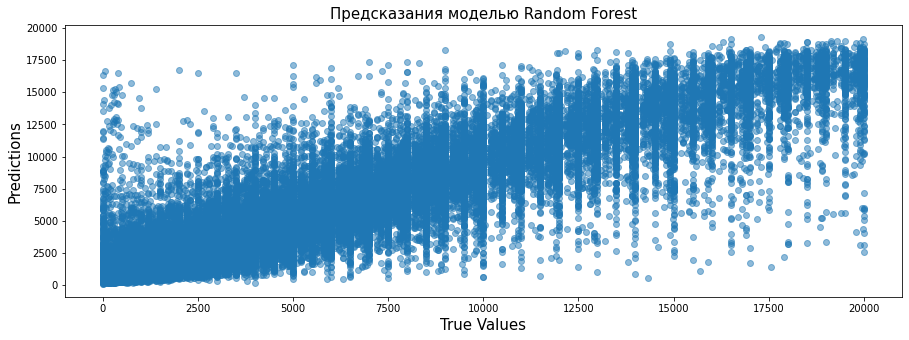

In [100]:
# визуализируем результаты предсказания
plt.figure(figsize = (15, 5))
plt.scatter(y_rf_valid, rf_predictions_valid, alpha=0.5)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Предсказания моделью Random Forest', fontsize=15);

### Cat Boost Regression

#### подготовка

In [101]:
# создаем список категориальных параметров
cat_features = list(['Model', 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'Brand_RegYear', 'Brand_Model'])
display(cat_features)

['Model',
 'VehicleType',
 'Gearbox',
 'FuelType',
 'Brand',
 'NotRepaired',
 'Brand_RegYear',
 'Brand_Model']

**подбор лучших гиперпараметров и кросс-валидация**

In [102]:
# подбираем лучшие гиперпараметры depth и learning_rate и проверяем результат кросс-валидации
catboost = CatBoostRegressor(loss_function='RMSE')
params = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
search_results = catboost.randomized_search (params, X_rf_train, y_train, cv=5)
print('Best Params:', search_results['params'])

0:	learn: 5941.2122175	test: 5892.4973570	best: 5892.4973570 (0)	total: 93.9ms	remaining: 1m 33s
1:	learn: 5479.0657846	test: 5430.5722739	best: 5430.5722739 (1)	total: 129ms	remaining: 1m 4s
2:	learn: 5074.3293379	test: 5027.6449430	best: 5027.6449430 (2)	total: 172ms	remaining: 57s
3:	learn: 4713.8450675	test: 4668.3164128	best: 4668.3164128 (3)	total: 206ms	remaining: 51.4s
4:	learn: 4396.4187604	test: 4350.0079863	best: 4350.0079863 (4)	total: 248ms	remaining: 49.3s
5:	learn: 4116.9819435	test: 4069.8150917	best: 4069.8150917 (5)	total: 289ms	remaining: 48s
6:	learn: 3866.1416248	test: 3819.3306762	best: 3819.3306762 (6)	total: 329ms	remaining: 46.7s
7:	learn: 3650.3824858	test: 3603.7851282	best: 3603.7851282 (7)	total: 374ms	remaining: 46.3s
8:	learn: 3457.9164661	test: 3412.2897322	best: 3412.2897322 (8)	total: 404ms	remaining: 44.5s
9:	learn: 3293.5694814	test: 3248.4065300	best: 3248.4065300 (9)	total: 436ms	remaining: 43.1s
10:	learn: 3149.8261505	test: 3104.5545420	best: 310

#### обучение и предсказание

In [103]:
%%time
# обучаем лучшую модель
cat_model = CatBoostRegressor(random_state = 0, depth = 10, learning_rate = 0.1)
cat_model.fit(X_train, y_train, cat_features = cat_features, verbose=100)

0:	learn: 4218.3491463	total: 823ms	remaining: 13m 42s
100:	learn: 1630.6607518	total: 1m 12s	remaining: 10m 43s
200:	learn: 1534.9781208	total: 2m 28s	remaining: 9m 52s
300:	learn: 1473.2406656	total: 3m 46s	remaining: 8m 46s
400:	learn: 1426.3221002	total: 5m 9s	remaining: 7m 41s
500:	learn: 1389.2270040	total: 6m 28s	remaining: 6m 27s
600:	learn: 1359.9631229	total: 7m 47s	remaining: 5m 10s
700:	learn: 1332.4958859	total: 9m 7s	remaining: 3m 53s
800:	learn: 1305.5818352	total: 10m 28s	remaining: 2m 36s
900:	learn: 1280.6056900	total: 11m 59s	remaining: 1m 19s
999:	learn: 1258.4111454	total: 13m 29s	remaining: 0us
CPU times: user 13min 24s, sys: 2.93 s, total: 13min 27s
Wall time: 13min 34s


In [104]:
%%time
# делаем прогноз,
# выводим метрику RMSE
cat_predictions_valid = cat_model.predict(X_valid)
print('Метрика RMSE при автоматическом прогнозе на валидационной выборке по модели Cat Boost')
print('RMSE: {:.2f}'.format(sqrt(mean_squared_error(y_valid, cat_predictions_valid))))

Метрика RMSE при автоматическом прогнозе на валидационной выборке по модели Cat Boost
RMSE: 1603.14
CPU times: user 2.37 s, sys: 7.89 ms, total: 2.37 s
Wall time: 2.39 s


#### визуализация

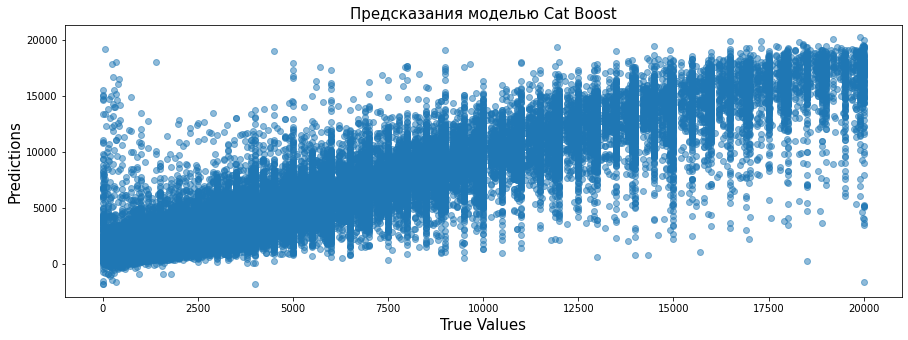

In [105]:
# визуализируем результаты предсказания
plt.figure(figsize = (15, 5))
plt.scatter(y_valid, cat_predictions_valid, alpha=0.5)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Предсказания моделью Cat Boost', fontsize=15);

### LightGBM

#### подготовка

**деление на выборки**

In [106]:
# разделяем данные на обучающую и валидационную выборки в пропорции 75х25
X_lgb_train = X_train.copy()
X_lgb_valid = X_valid.copy()
y_lgb_train = y_train.copy()
y_lgb_valid = y_valid.copy()

In [107]:
# проверяем количество измерений в выборках
print(X_lgb_train.shape)
print(y_lgb_train.shape)
print(X_lgb_valid.shape)
print(y_lgb_valid.shape)

(231480, 14)
(231480,)
(77160, 14)
(77160,)


**преобразование в категориальный тип данных**

In [108]:
# приводим значения категориальных параметров к категориальному типу данных
for feature in cat_features:
    X_lgb_train[feature] = pd.Series(X_lgb_train[feature], dtype="category")
    X_lgb_valid[feature] = pd.Series(X_lgb_valid[feature], dtype="category")
display(X_lgb_train.dtypes)
display(X_lgb_valid.dtypes)

index                   int64
Model                category
VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                 float64
Kilometer               int64
RegistrationMonth       int64
FuelType             category
Brand                category
NotRepaired          category
PostalCode              int64
Brand_Model          category
Brand_RegYear        category
dtype: object

index                   int64
Model                category
VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                 float64
Kilometer               int64
RegistrationMonth       int64
FuelType             category
Brand                category
NotRepaired          category
PostalCode              int64
Brand_Model          category
Brand_RegYear        category
dtype: object

**кросс-валидация**

In [109]:
# проводим кросс-валидацию для модели
dftrainLGB = lgb.Dataset(data = X_lgb_train, label = y_lgb_train, feature_name = list(X_lgb_train))

params = {'objective': 'regression', 'force_col_wise': 'true'}
    
cv_results = lgb.cv(
        params,
        dftrainLGB,
        num_boost_round=200,
        nfold=5,
        metrics='rmse',
        stratified=False,
        shuffle=True,
        verbose_eval=True
        )

[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 185184, number of used features: 14
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 185184, number of used features: 14
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 185184, number of used features: 14
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 185184, number of used features: 14
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 185184, number of used features: 14


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score 4568.636000
[LightGBM] [Info] Start training from score 4572.045776
[LightGBM] [Info] Start training from score 4570.667082
[LightGBM] [Info] Start training from score 4569.660786
[LightGBM] [Info] Start training from score 4575.391794
[1]	cv_agg's rmse: 4208.56 + 11.554
[2]	cv_agg's rmse: 3915.91 + 10.9934
[3]	cv_agg's rmse: 3659.65 + 11.2985
[4]	cv_agg's rmse: 3432.89 + 12.005
[5]	cv_agg's rmse: 3231.58 + 12.0317
[6]	cv_agg's rmse: 3056.1 + 12.702
[7]	cv_agg's rmse: 2899.88 + 12.8738
[8]	cv_agg's rmse: 2762.96 + 13.6065
[9]	cv_agg's rmse: 2641.82 + 13.6307
[10]	cv_agg's rmse: 2534.57 + 14.3573
[11]	cv_agg's rmse: 2438.64 + 14.3348
[12]	cv_agg's rmse: 2354.88 + 13.7108
[13]	cv_agg's rmse: 2280.7 + 13.616
[14]	cv_agg's rmse: 2217.28 + 14.6743
[15]	cv_agg's rmse: 2159.48 + 13.963
[16]	cv_agg's rmse: 2109.92 + 13.6525
[17]	cv_agg's rmse: 2064.29 + 14.4198
[18]	cv_agg's rmse: 2023.91 + 14.2448
[19]	cv_agg's rmse: 1989.13 + 14.0828
[20]	cv_agg's 

#### обучение и предсказание

In [110]:
%%time
# обучаем модель с параметрами по умолчпнию
lgb_model = LGBMRegressor(random_state = 0, boosting_type='gbdt')
lgb_model.fit(X_lgb_train, y_lgb_train, eval_set = (X_lgb_valid, y_lgb_valid), verbose=False)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: user 10.5 s, sys: 20.1 ms, total: 10.5 s
Wall time: 10.7 s


LGBMRegressor(random_state=0)

In [111]:
%%time
# делаем прогноз,
# выводим метрику RMSE
lgb_predictions_valid = lgb_model.predict(X_lgb_valid)
print('Метрика RMSE при автоматическом прогнозе на валидационной выборке по модели LGBM')
print('RMSE: {:.2f}'.format(sqrt(mean_squared_error(y_lgb_valid, lgb_predictions_valid))))

Метрика RMSE при автоматическом прогнозе на валидационной выборке по модели LGBM
RMSE: 1666.89
CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.19 s


#### визуализация

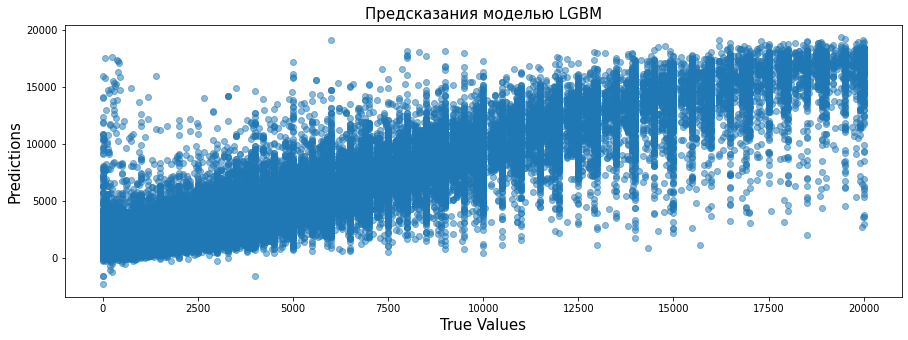

In [112]:
# визуализируем результаты предсказания
plt.figure(figsize = (15, 5))
plt.scatter(y_lgb_valid, lgb_predictions_valid, alpha=0.5)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Предсказания моделью LGBM', fontsize=15);

## Анализ моделей

In [113]:
# делаем сводную таблицу результатов
model_best = pd.DataFrame(columns=(['model', 'cv_score_RMSE', 'time_fit', 'time_predict']))
model_best.model = ['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
model_best['cv_score_RMSE'] = [1838, 1585, 1643]
model_best.time_fit = ['1 min 18 s', '14 min 54 s', '1 min 21 s']
model_best.time_predict = ['1 min 46 s', '2 min 34 s', '973    ms']

display(model_best.sort_values(by='cv_score_RMSE'))

,model,cv_score_RMSE,time_fit,time_predict
1,CatBoostRegressor,1585,14 min 54 s,2 min 34 s
2,LGBMRegressor,1643,1 min 21 s,973 ms
0,RandomForestRegressor,1838,1 min 18 s,1 min 46 s


* в рамках проекта были исследованы 3 варианта моделей: RandomForestRegressor, CatBoostRegressor, LGBMRegressor
* **RandomForestRegressor**: для преобразования категорийных признаков в численные было применено прямое кодирование (Ordinal Encoding), а также для подбора лучших гиперпараметров был применен RandomizedSearchCV
* **CatBoostRegressor**: категорийные признаки не подвергались модификациям, для подбора лучших гиперпараметров был применен RandomizedSearchCV
* **LGBMRegressor**: данные категорийных признаков были приведены к категориальному типу, модель отработала с параметрами по умолчанию
* **лучший** результат по метрике **RMSE** на кросс-валидации показал **CatBoostRegressor**. Следующим по качеству идет LGBMRegressor, на последнем месте RandomForestRegressor. Разница между между CatBoost и LGBM не сильно большая в рамках поставленной задачи определения цены автомобиля: 1585 vs 1643
* при этом **CatBoostRegressor** оказался последним по **скорости обучения и предсказания**. Однако стоит учесть тот факт, что модель самостоятельно обрабатывает категорийные признаки, т.е. исследователь не тратит на это время и ресурсы в ходе подготовки данных

### Вывод:
* учитывая, что для заказчика важны точность и скорость, предлагается обсудить варианты катбуста и лгбм, возможно мощности заказчика позволят ускорить работу катбуста; в противном случае предпочтительнее будет лгбм, у которой средний результат по точности и лучший по скорости предсказания, что может быть критичным для работы приложения 